In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from time import sleep
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import OPTICS
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import direct_input

In [45]:
def get_azimut_image(img):
    return img[57:73,945:975]
    
def get_azimut_digits(azimut_img,two_digit=False):
    if two_digit:
        return [(azimut_img[:,5:25][:,i*10:i*10+10][:,:,[0,1,2]].mean(axis=2)) for i in range(2)]
    else:
        return [(azimut_img[:,i*10:i*10+10][:,:,[0,1,2]].mean(axis=2)) for i in range(3)]

def getScreenShot(bbox):
    return np.array(ImageGrab.grab(bbox))

def roun_to_base(x, base=5):
    return base * round(x/base)

def get_azimut_shot(img):
    return img[20:73,910:1010]

def get_azimuth_from_shot(img):
    return img[37:,35:65]

def get_percise_asimut_from_shot(img):
    return img[25:30,50:96]
    

1562787756

In [28]:
from PIL import ImageGrab
import keyboard

path = "compas_shots\\"

while(not keyboard.is_pressed('F7')):
    pass

for angle in range(0,180):    
    img = getScreenShot((0,0,1920,1080))
    img = img[20:73,910:1010]
    plt.imsave(path + f"compas_{angle*2}_{int(time.time())}.jpg",img)
    direct_input.mouse_move(45,0)
    sleep(0.1)

In [40]:
image_files = ["compas_shots\\" + fname for fname in os.listdir('compas_shots') if fname[-4:]=='.jpg']

In [3]:
percise_img_files = ["compas_shots_precise\\" + fname for fname in os.listdir('compas_shots_precise') if fname[-4:]=='.jpg']
percise_imgs = np.array([plt.imread(percise_img_file) for percise_img_file in  percise_img_files])
percise_angle = np.array([int(percise_img_file.split('_')[3]) for percise_img_file in percise_img_files])


In [30]:
X = [img[:,:,[0,1,2]].mean(axis=2)[25:30,50:96].flatten() for img in percise_imgs]

In [35]:
%%time
clf_percise_azimuth = LogisticRegression(solver='lbfgs',multi_class='auto',n_jobs=-1,max_iter=500,random_state=42)
clf_percise_azimuth.fit(X,percise_angle)

Wall time: 1min


In [38]:
clf_percise_azimuth.score(X,percise_angle)

0.6343461932400136

In [39]:
np.abs(clf_percise_azimuth.predict(X)//22.5 - np.array(percise_angle)//22.5).mean()


0.09627859337657904

In [34]:
fail = (clf.predict(X)) != (np.array(percise_angle))
1-fail.mean()

0.8900648685558211

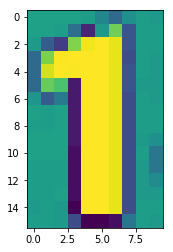

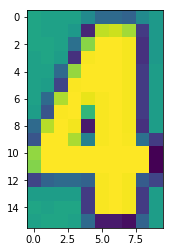

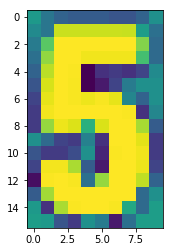

In [302]:
asimut_digits = get_azimut_digits(azimuth_img)
for digit in asimut_digits:
    plt.imshow(preprocess(digit*10))
    plt.show()

In [48]:
X = []
true_digits = []
came_from_file = []

replace_vals = dict(zip(['0','45','90','135','180','225','270','315','360'],['N','NE','E','SE','S','SW','W','NW','N']))

for file in image_files:
    img = plt.imread(file)
    str_digits = (str(roun_to_base(int(file.split('compas_')[2].split('_')[0]))))
    
    if str_digits in replace_vals:
        str_digits = replace_vals[str_digits]
    
    if(len(str_digits) == 1):
        str_digits = ' '+str_digits+' '
        true_digits +=  list(str_digits)
    elif(len(str_digits) == 2):
        true_digits += ['two-digit']*3
    else:
        true_digits += list(str_digits)     
    came_from_file += [file]*3    
    X = X + [preprocess(digit) for digit in get_azimut_digits(get_azimuth_from_shot(img))]    
X = np.array(X)
true_digits = np.array(true_digits)
came_from_file = np.array(came_from_file)


In [49]:
clf_azimuth_digits = LogisticRegression(C=20,penalty='l2')
clf_azimuth_digits.fit(X,true_digits)
clf_azimuth_digits.score(X,true_digits)

D:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Programs\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


1.0

In [165]:
def preprocess(img):
    if img.max()>1:
        return (img/255).flatten()
    else:
        return img.flatten()
    
def get_azimut_digits(azimut_img,two_digit=False):
    if two_digit:
        return [(azimut_img[:,5:25][:,i*10:i*10+10][:,:,[0,1,2]].mean(axis=2)) for i in range(2)]
    else:
        return [(azimut_img[:,i*10:i*10+10][:,:,[0,1,2]].mean(axis=2)) for i in range(3)]

def azimuth_from_image(img):
    digits = [preprocess(digit) for digit in get_azimut_digits(get_azimut_image(img))]
    preds = clf_azimuth_digits.predict(digits)
    if 'two-digit' in preds:
        preds = clf_azimuth_digits.predict([preprocess(digit) for digit in get_azimut_digits(img,two_digit=True)])
    replace_vals = dict(zip([' N ','NE',' E ','SE',' S ','SW',' W ','NW',' N '],
                            [ '0', '45','90','135','180','225','270','315','360']))
    pred = ''.join(preds)
    if pred in replace_vals:
        pred = replace_vals[pred]
        
    percise_img = img[20:73,910:1010][25:30,50:96][:,:,[0,1,2]].mean(axis=2).flatten()
    if percise_img.max()<=1:
        percise_img = percise_img*255
    percise_pred = clf_percise_azimuth.predict([percise_img])
    pred = int(pred)
    pred = pred//15 * 15
    pred_shift = (percise_pred[0]/22.5)
    if pred_shift >= 13:
        pred = pred-15
    return pred + pred_shift
    
    

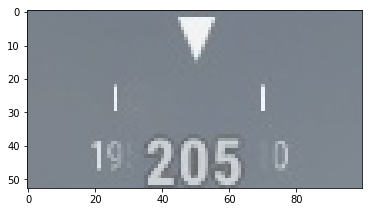

203.0


In [166]:
full_img_files = ['data\\' + x for x in os.listdir('data')]
img = plt.imread(full_img_files[33])
# img = get_azimut_image(img)
plt.imshow(get_azimut_shot(img))
plt.show()
print(azimuth_from_image(img))


In [164]:
import pickle
with open('azimut_digit_detector_clf.plk', 'wb') as f:
    pickle.dump(clf_azimuth_digits, f)

with open('azimut_percise_detector_clf.plk', 'wb') as f:
    pickle.dump(clf_percise_azimuth, f)

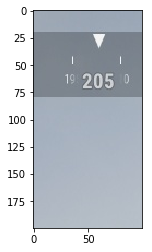

203.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LogisticRegression
import pickle

with open('azimut_digit_detector_clf.plk', 'rb') as f:
    azimut_digit_detector_clf = pickle.load(f)

with open('azimut_percise_detector_clf.plk', 'rb') as f:
    azimut_percise_detector_clf = pickle.load(f)
    
def preprocess(img):
    if img.max()>1:
        return (img/255).flatten()
    else:
        return img.flatten()
    
def get_azimut_digits(azimut_img,two_digit=False):
    if two_digit:
        return [(azimut_img[:,5:25][:,i*10:i*10+10][:,:,[0,1,2]].mean(axis=2)) for i in range(2)]
    else:
        return [(azimut_img[:,i*10:i*10+10][:,:,[0,1,2]].mean(axis=2)) for i in range(3)]
    
def get_azimut_image(img):
    return img[57:73,945:975]

def azimuth_from_image(img):
    digits = [preprocess(digit) for digit in get_azimut_digits(get_azimut_image(img))]
    preds = azimut_digit_detector_clf.predict(digits)
    if 'two-digit' in preds:
        preds = azimut_digit_detector_clf.predict([preprocess(digit) for digit in get_azimut_digits(img,two_digit=True)])
    replace_vals = dict(zip([' N ','NE',' E ','SE',' S ','SW',' W ','NW',' N '],
                            [ '0', '45','90','135','180','225','270','315','360']))
    pred = ''.join(preds)
    if pred in replace_vals:
        pred = replace_vals[pred]
        
    percise_img = img[20:73,910:1010][25:30,50:96][:,:,[0,1,2]].mean(axis=2).flatten()
    if percise_img.max()<=1:
        percise_img = percise_img*255
    percise_pred = azimut_percise_detector_clf.predict([percise_img])
    pred = int(pred)
    pred = pred//15 * 15
    pred_shift = (percise_pred[0]/22.5)
    if pred_shift >= 13:
        pred = pred-15
    return pred + pred_shift

full_img_files = ['data\\' + x for x in os.listdir('data')]
img = plt.imread(full_img_files[33])
plt.imshow(img[:200,900:1000])
plt.show()
print(azimuth_from_image(img))

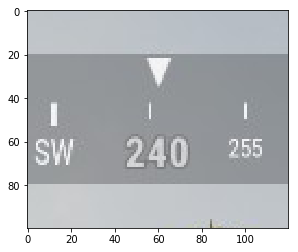

241.022


In [8]:
from  azimuth_detector import azimuth_from_image
import os
import matplotlib.pyplot as plt

full_img_files = ['data\\' + x for x in os.listdir('data')]
img = plt.imread(full_img_files[14])
plt.imshow(img[:100,900:1020])
plt.show()
print(round(azimuth_from_image(img),3))

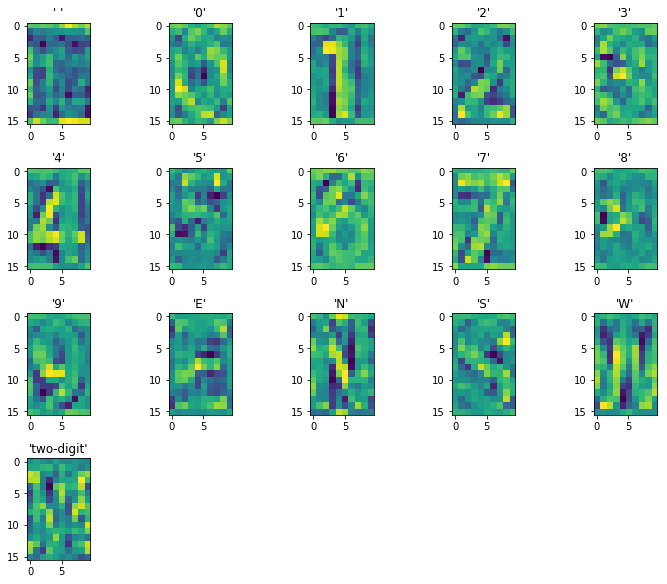

In [46]:
f,a  = plt.subplots(ncols=5,nrows=5,figsize=(10,10))

for ax,coef,title in zip(a.flatten()[:len(clf.classes_)],clf.coef_,clf.classes_):
    ax.imshow(coef.reshape(16,10))
    ax.set_title("'" + title + "'")
    
for ax in a.flatten()[len(clf.classes_):]:
    ax.remove()
    
plt.tight_layout()   
plt.show()